# Import


In [1]:
import numpy as np
import pandas as pd
import glob
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import keras

import cv2

# New Section


In [2]:
df=pd.read_csv('../dataset/XSS2.csv', encoding='utf-8-sig')
df.head()

,No,Sentence,Label
0,0,"boom of the 1980s: rise of <a href=""/wiki/expe...",0
1,1,/vulnerabilities/fi/,0
2,2,"<div draggable=""true"" contenteditable>drag me<...",1
3,3,"<template onmouseleave=""alert(1)"">test</template>",1
4,4,<style>@keyframes x{from {left:0;}to {left: 10...,1


In [3]:
df=df[df.columns[-2:]]
df.head()

,Sentence,Label
0,"boom of the 1980s: rise of <a href=""/wiki/expe...",0
1,/vulnerabilities/fi/,0
2,"<div draggable=""true"" contenteditable>drag me<...",1
3,"<template onmouseleave=""alert(1)"">test</template>",1
4,<style>@keyframes x{from {left:0;}to {left: 10...,1


In [4]:
df['Label'].value_counts()

Label
1    7490
0    3703
Name: count, dtype: int64

In [5]:
# Prepocess
data = df['Sentence'].values
label = df['Label'].values

trainX, testX, trainY, testY = train_test_split(data, label, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenization and word embedding
max_sequence_length = 1000  # Maximum sequence length
max_num_words = 1000  # Maximum number of unique words

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(trainX)

In [7]:
import json

# Save the tokenizer's word-to-index mapping to a JSON file
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as json_file:
    json.dump(tokenizer_json, json_file, ensure_ascii=False, indent=4)

In [8]:
trainX_sequences = tokenizer.texts_to_sequences(trainX)
testX_sequenceS = tokenizer.texts_to_sequences(testX)
del trainX,testX

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
trainX_padded = pad_sequences(trainX_sequences,max_sequence_length)
testX_padded = pad_sequences(testX_sequenceS,max_sequence_length)
del trainX_sequences,testX_sequenceS

In [10]:
from sklearn.preprocessing import LabelEncoder

#Encoding labels
label_encoder = LabelEncoder()

y_train =  label_encoder.fit_transform(trainY)
y_test = label_encoder.transform(testY)


In [11]:
# import libraries for Making Model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D,Flatten,Dropout,MaxPool2D, BatchNormalization, LSTM, TimeDistributed, Reshape

In [27]:

import tensorflow as tf
# LSTM model configuration
embedding_dim = 100   # Dimensionality of the word embeddings
lstm_units = 128    # Number of LSTM units
def get_sequential_model(max_len=1000):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=1000,  output_dim=1000, input_length=max_len, trainable=False),
        tf.keras.layers.Conv1D(32, 5, padding='same', strides=1, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=3),
        tf.keras.layers.Conv1D(32, 10, padding='same', strides=1, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=3),
        tf.keras.layers.Conv1D(32, 15, padding='same', strides=1, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=3),
        tf.keras.layers.Reshape((int(max_len/(3**3)), 32)),  # Reshape output of CNN to fit into LSTM
        # tf.keras.layers.LSTM(256, return_sequences=True),  # LSTM layer with return_sequences=True
        tf.keras.layers.LSTM(units=128),  # Another LSTM layer with 128 units
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [28]:
model = get_sequential_model(max_len=1000)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1000, 1000)        1000000   
                                                                 
 conv1d_15 (Conv1D)          (None, 1000, 32)          160032    
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 333, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 333, 32)           10272     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 111, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 111, 32)          

In [29]:
# Stop when validation accuracy > 97

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print(" \n Reached 98% + validation accuracy")
            self.model.stop_training=True
callbacks = myCallback()

In [30]:
batch_size = 128
num_epoch = 20
model_log = model.fit(
    trainX_padded, 
    y_train,
    batch_size=batch_size,
    epochs=num_epoch,
    verbose=1,
    validation_data=(testX_padded, y_test)
)


Epoch 1/50
70/70 [==============================] - 13s 159ms/step - loss: 0.2636 - accuracy: 0.8575 - val_loss: 0.0369 - val_accuracy: 0.9866
Epoch 2/50
70/70 [==============================] - 10s 144ms/step - loss: 0.0246 - accuracy: 0.9923 - val_loss: 0.0141 - val_accuracy: 0.9964
Epoch 3/50
70/70 [==============================] - 10s 144ms/step - loss: 0.0110 - accuracy: 0.9968 - val_loss: 0.0091 - val_accuracy: 0.9964
Epoch 4/50
70/70 [==============================] - 10s 144ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.0149 - val_accuracy: 0.9955
Epoch 5/50
70/70 [==============================] - 10s 144ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0095 - val_accuracy: 0.9969
Epoch 6/50
70/70 [==============================] - 10s 144ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.0111 - val_accuracy: 0.9973
Epoch 7/50
70/70 [==============================] - 10s 144ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.0138 - val_accuracy: 0.9969

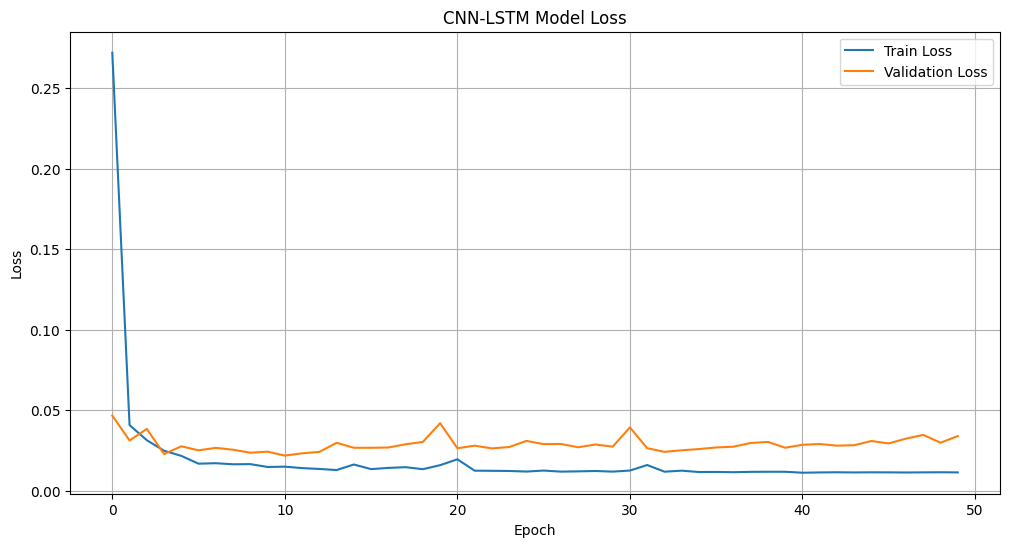

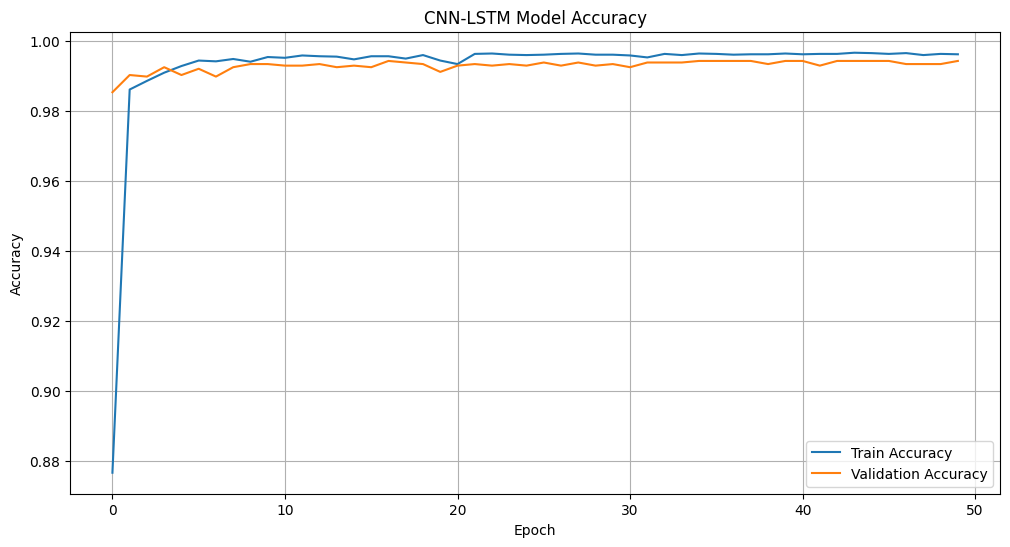

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 6))
plt.plot(model_log.history['loss'], label='Train Loss')
plt.plot(model_log.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Vẽ biểu đồ Accuracy
plt.figure(figsize=(12, 6))
plt.plot(model_log.history['accuracy'], label='Train Accuracy')
plt.plot(model_log.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# predict for test set
pred=model.predict(testX_padded)

70/70 [==============================] - 1s 11ms/step


In [ ]:
model.save("../web/models/CNN-LSTM1D.keras")
#loaded_model = keras.models.load_model("../web/models/CNN-LSTM.keras")
#assert np.allclose(model.predict(testX), loaded_model.predict(testX))

In [ ]:
# Threshold values predicted

for i in range(len(pred)):
    if pred[i]>0.5:
        pred[i]=1
    elif pred[i]<=0.5:
        pred[i]=0


In [ ]:
# Count True predicted and wrong predicted

true=0
false=0

for i in range(len(pred)):
    if pred[i] == testY[i]:
        true+=1
    else:
        false+=1

print("correct predicted :: ", true)
print("false prediction :: ", false)

correct predicted ::  2226
false prediction ::  13


In [ ]:
# Number of attack and benign data in test set

attack=0
benign=0
for i in range(len(testY)):
    if testY[i]==1:
        attack+=1
    else:
        benign+=1

print("Attack data in test set :: ", attack)
print(" Benign data in test set :: ", benign)

Attack data in test set ::  1479
 Benign data in test set ::  760


## Confusion Matrix

In [ ]:
# Takes True positive, true negative, false positive and false negative as input
# Returns Accuracy

def accuracy_function(tp,tn,fp,fn):

    accuracy = (tp+tn) / (tp+tn+fp+fn)

    return accuracy

In [ ]:
# Takes True Positive and false positive
# Returns Precision

def precision_function(tp,fp):

    precision = tp / (tp+fp)

    return precision

In [ ]:
#Takes True Positive and false negative
# Returns Recall

def recall_function(tp,fn):

    recall=tp / (tp+fn)

    return recall

In [ ]:
def f1_function(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1


In [ ]:
#Takes true values and predicted
# Returns Accuracy, precision and recall


def confusion_matrix(truth,predicted):
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    for true,pred in zip(truth,predicted):
        if true == 1:
            if pred == true:
                true_positive += 1
            elif pred != true:
                false_negative += 1

        elif true == 0:
            if pred == true:
                true_negative += 1
            elif pred != true:
                false_positive += 1
    
    accuracy=accuracy_function(true_positive, true_negative, false_positive, false_negative)
    precision=precision_function(true_positive, false_positive)
    recall=recall_function(true_positive, false_negative)
    f1 = f1_function(true_positive,false_positive,false_negative)
    
    print(f"True Positive: {true_positive}")
    print(f"True Negative: {true_negative}")
    print(f"False Positive: {false_positive}")
    print(f"False Negative: {false_negative}")
    return (accuracy,
            precision,
            recall,
            f1)

In [ ]:
accuracy, precision, recall, f1= confusion_matrix(testY,pred)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1-score: {3} ".format(accuracy, precision, recall, f1))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Giả định testY là nhãn thực và pred là nhãn dự đoán
accuracy = accuracy_score(testY, pred)
precision = precision_score(testY, pred)
recall = recall_score(testY, pred)
f1 = f1_score(testY, pred)

print("Accuracy: {0:.4f} \nPrecision: {1:.4f} \nRecall: {2:.4f} \nF1-score: {3:.4f}".format(accuracy, precision, recall, f1))

 Accuracy : 0.994193836534167 
 Precision : 0.9972862957937585 
 Recall : 0.9939148073022313 
 F1-score: 0.9912339851652057 


In [ ]:
from openpyxl import Workbook, load_workbook
from openpyxl.styles import PatternFill, Alignment

models = {
    "BiLSTM":2,
    "LSTM-GAP":3,
    "CNN":4,
    "CNN-LSTM":5,
    "TextCNN":6
}

file_name = "model_performance.xlsx"
try:
    wb = load_workbook(file_name)
except FileNotFoundError:
    # Nếu file không tồn tại, tạo một workbook mới
    wb = Workbook()
    sheet = wb.active
    # Đặt màu nền cho dòng header
    header_fill = PatternFill(start_color="92D050", end_color="92D050", fill_type="solid")

    # Đặt tiêu đề cho các hàng và cột
    sheet.cell(row=1, column=1).value = "Metric"
    sheet.cell(row=1, column=1).fill = header_fill
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "Correct Predict", "False Predict"]
    for row, metric in enumerate(metrics, start=2):
        cell = sheet.cell(row=row, column=1)
        cell.value = metric
    
    for col, model_name in enumerate(models, start=2):
        cell = sheet.cell(row=1, column=col)
        cell.value = model_name
        cell.alignment = Alignment(horizontal="center", vertical="center")
        cell.fill = header_fill

    # Lưu file Excel mới
    wb.save(file_name)
    wb = load_workbook(file_name)

sheet = wb.active
sheet.column_dimensions['A'].width = 15
model_name = "CNN-LSTM"
col = models[model_name]
# Ghi dữ liệu của từng mô hình vào cột tương ứng

sheet.cell(row=2, column=col).value = f"{accuracy*100:.2f}%"
sheet.cell(row=2, column=col).alignment = Alignment(horizontal="center", vertical="center")
sheet.cell(row=3, column=col).value = f"{precision*100:.2f}%"
sheet.cell(row=3, column=col).alignment = Alignment(horizontal="center", vertical="center")
sheet.cell(row=4, column=col).value = f"{recall*100:.2f}%"
sheet.cell(row=4, column=col).alignment = Alignment(horizontal="center", vertical="center")
sheet.cell(row=5, column=col).value = f"{f1*100:.2f}%"
sheet.cell(row=5, column=col).alignment = Alignment(horizontal="center", vertical="center")
sheet.cell(row=6, column=col).value = true
sheet.cell(row=6, column=col).alignment = Alignment(horizontal="center", vertical="center")
sheet.cell(row=7, column=col).value = false
sheet.cell(row=7, column=col).alignment = Alignment(horizontal="center", vertical="center")

# Lưu file Excel sau khi thêm dữ liệu
wb.save(file_name)
